# Data Preprocessing

## Import Packages and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pickle
#import category_encoders as ce

from datetime import date
import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
listing = pd.read_csv('roofstock_marketplace_listing_historical_full.csv')
transaction = pd.read_csv('roofstock_marketplace_transactions_full.csv')
offer = pd.read_csv('roofstock_marketplace_offers_full.csv')
buyer = pd.read_csv('roofstock_marketplace_buyers_full.csv')
df = pd.read_csv('latter_final.csv')

## Create New Variables
* HOUSEAGE: the difference of YEARBUILT and current date

* OFFER_OR_NOT: whether a listing has offer(s) or not

* Diff_days: the difference of PUBLISHED_INITIAL_TS of a listing and EVENT_UTC of an offer.

* INITIAL_PUBLISH_MONTH: extract month from LISTING_INITIAL_PUBLISH_DATE

* OFFER_MONTH: extract month from EVENT_UTC

In [3]:
#### HOUSEAGE
now = datetime.datetime.now()
df['HOUSEAGE'] = now.year - df.YEARBUILT
df = df.drop('YEARBUILT',axis=1)

#### OFFER_OR_NOT
listingID = offer.LISTING_ID
offer_or_not = []
for i in range(len(df)):
    if listing.iloc[i]['LISTING_ID'] in listingID.values:
        offer_or_not.append(1)
    else:
        offer_or_not.append(0)
offer_or_not = pd.Series(offer_or_not)
df['OFFER_OR_NOT'] = offer_or_not   

#### OFFER_MONTH
df['LISTING_INITIAL_PUBLISH_TS']=pd.to_datetime(df['LISTING_INITIAL_PUBLISH_TS'])
df_offer=df[df['OFFER_OR_NOT']==1]
df_no_offer=df[df['OFFER_OR_NOT']==0]
df_offer['EVENT_UTC']=pd.to_datetime(df_offer['EVENT_UTC'])
df_time=df.set_index('LISTING_INITIAL_PUBLISH_TS')
df_time['INITIAL_PUBLISH_MONTH']=df_time.index.month
df_offer=df_offer.set_index('EVENT_UTC')
df_offer['OFFER_MONTH']=df_offer.index.month

#### INITIAL_PUBLISH_MONTH
df['LISTING_INITIAL_PUBLISH_TS']=pd.to_datetime(df['LISTING_INITIAL_PUBLISH_TS'])
df_time=df.set_index('LISTING_INITIAL_PUBLISH_TS')
df_time['INITIAL_PUBLISH_MONTH']=df_time.index.month

## Delete Variables
* Text/ Unstructured feature: 
such as PROPERTYHIGHLIGHTS
* Features with over 50% missing values: 
such as  RESERVEDEPOSIT, all NAs
* Features explaining the same things: 
such as LISTING_SOURCE_ID and LISTING_SOURCE, only maintain the latter one.
* Useless Features: such as VIRTUALTOURURL
* Unique Identifier: such as ACCOUNT_ID

In [4]:
droplist=['REC_START_TS','REC_END_TS','CERTIFICATION_ID','ACCOUNT_ID','LISTING_STATUS_TYPE',
'COUNTRY','OPENHOUSE_PUBLISH_TS','OPENHOUSE_CONSIDER_OFFERS_TS','OPENHOUSE_END_TS',
'LISTING_SOURCE_ID', 'PROPERTYHIGHLIGHTS','PROPERTYMARKETINGPOINTS',
'VIRTUALTOURURL','MLSMODIFICATIONTIMESTAMP','SALE_PRICE',
'MONTHLYMANAGEMENTFEES','TURNOVER_FEE','AVMBPOADJVALUE',
'COMPUTEDRESERVEDEPOSIT','RESERVEDEPOSIT','MONTHLYASSETMANAGEMENTFEE',
'OCCUPANCYLASTUPDATEDDATE','LEASESTARTDATE','LEASEENDDATE','NOTES',
'ADDRESS1','ADDRESS2','CITY','DISTRICT','COUNTY','ZIP','ZIPPLUS4','EVENT_UTC','CREATED_TS',
'LISTING_ID','ATTICCONDITIONID','BASEMENTCONDITIONID','BATHROOMSCONDITIONID','BEDROOMSCONDITIONID',
'ELECTRICALCONDITIONID','EST_VALUATION','EXTERIORCONDITIONID','FEATUREDREASON','GARAGECONDITIONID','HVACCONDITIONID',
'INSPECTION_CONTINGENCY_REASON_ID','SOLD_DATE','STORIES','STRUCTURALCONDITIONID','UNITS',
'YEARLYCAPITALEXPENDITURESCOST','YEARLYREPAIRSMAINTENANCECOST','LISTING_INITIAL_PUBLISH_TS',
'LISTING_INTIAL_PUBLISH_DATE','LISTING_PUBLISH_DATE','LISTING_PUBLISH_TS','PROPERTY_ID','SALES_PENDING_DATE',
'PREVIOUS_ESCROW_CLOSING_DATE','EST_RENT_LOW','EST_RENT_HIGH','COMPUTEDRESERVEDEPOSITPERCENTAGE', 'Unnamed: 0',
'COMPUTEDDOWNPAYMENT','MARKETEDRENT','LATEPAYMENTMONTHS','PETFEEAMOUNT','PETSDEPOSITAMOUNT','RSRENTESTIMATE','AVMBPOVALUE']
df = df.drop(droplist,axis=1)

In [5]:
droplist = ['GMAPPOVLATITUDE','GMAPPOVLONGITUDE','EST_VALUATION_HIGH','EST_VALUATION_LOW',
           'LATITUDE','LONGITUDE']

df = df.drop(droplist,axis=1)

## Fill Missing Value
* Categorical feature: 
create a new level
* Numerical feature: 
group by STATE, 
filtered with price range of +- 20000,
then fill NA with the group’s median


In [7]:
#### Correct STATE column
df.loc[df['STATE'] == 'Florida', 'STATE'] = 'FL'
df.loc[df['STATE'] == 'PA , 15001', 'STATE'] = 'PA'
#### Correct FLOODRISKSCORE column
df.loc[df['FLOODRISKSCORE'] == '\tX', 'FLOODRISKSCORE'] = 'X'
df.loc[df['FLOODRISKSCORE'] == 'x', 'FLOODRISKSCORE'] = 'X'
df.loc[df['FLOODRISKSCORE'] == '530400170009000', 'FLOODRISKSCORE'] = 'Null'
df.loc[df['FLOODRISKSCORE'] == '0.00', 'FLOODRISKSCORE'] = 'Null'

fill_list=['SQUAREFEET','BEDROOMS','BATHROOMS','MONTHLY_RENT','MARKET_RENT','YEARLYPROPERTYTAXES',
           'YEARLYINSURANCECOST','PREVIOUSYEARLYPROPERTYTAXES','EST_REPAIR_COST','COMPUTED_GROSS_YIELD',
           'COMPUTED_CAP_RATE','COMPUTEDTOTALEXPENSES','OWNERELECTRIC','OWNERGAS','OWNERWATER','OWNERGARBAGE',
           'OWNERPOOL','OWNERLANDSCAPING','OWNERPESTCONTROL','OWNERREFRIGERATOR','OWNERDISHWASHER','OWNERWASHER',
           'OWNERDRYER','OWNERMICROWAVE','OWNERSTOVE','MONTHLYHOA']
for i in fill_list:
    df[i]=df[i].fillna(-999999.)
    for j in list(df[df[i]== -999999.].index):
        state=df['STATE'][j]
        price=df['LIST_PRICE'][j]
        c_df=df[df['STATE']==state]
        cc_df=c_df[(c_df['LIST_PRICE']>=price-20000) & (c_df['LIST_PRICE'] <=price+20000)]
        cc_df=cc_df[cc_df[i]!=-999999.]
        fill_square=cc_df[i].median()
        df.set_value(j,i,fill_square)
    df[i]=df[i].fillna(df[i].median())  

In [8]:
#Fill missing value with 0
fillzero_list=['LOTSIZE','LONGITUDE','LATITUDE','GMAPPOVLONGITUDE','GMAPPOVLATITUDE','SCHOOLELEMENTARYSCORE',
           'SCHOOLMIDDLESCORE','SCHOOLHIGHSCORE','COMPUTEDTOTALEXPENSESPERCENTAGE','COMPUTEDCASHFLOW',
            'COMPUTEDAPPRECIATION','COMPUTEDLEVEREDIRR','COMPUTEDLEVEREDCASHONCASH','COMPUTEDLEVEREDNETYIELD',
            'COMPUTEDLEVEREDANNUALCASHFLOW','COMPUTEDTOTALRETURN','COMPUTEDTOTALOPERATINGEXPENSEPERCENT',
            'COMPUTEDLEVEREDINITIALOUTLAY','COMPUTEDLOANPAYMENTS','COMPUTEDEXPENSESANDRESERVES',
            'COMPUTEDEXPECTEDRENT','COMPUTEDDOWNPAYMENTPERCENTAGE','COMPUTEDPROPERTYTAXES','OCCUPANCY',
            'LEASEMONTHLYRENT', 'SECURITYDEPOSITAMOUNT','NEIGHBORHOODSCORE' ]
for i in fillzero_list:
    df[i]=df[i].fillna(0)

In [9]:
#Fill boolean type missing value with False
fillF_list=['HASPET','ISHOA','ISPOOL','ISPETSDEPOSIT','ISLEASECONCESSIONS','ISSECTION8','ISRENTERSINSURANCEREQUIRED',
            'ISTENANTBACKGROUNDCHECKED','ISTENANTINCOMEABOVE3X','ISTENANTMAYTERMINATEEARLY','ISTENANTPURCHASEOPTION',
           'GMAPHASSTREETVIEW']
for i in fillF_list:
    df[i]=df[i].fillna(False)

In [10]:
#Fill encoded type catogorical data with -9999
df['MARKET_ID']=df['MARKET_ID'].fillna(-9999.)
df['CBSA_CODE']=df['CBSA_CODE'].fillna(-99999.)
df['GMAPPOVHEADING']=df['GMAPPOVHEADING'].fillna(-9999.)
df['GMAPPOVPITCH']=df['GMAPPOVPITCH'].fillna(-9999.)
df['CERTIFICATIONLEVEL']=df['CERTIFICATIONLEVEL'].fillna(-9999)
df['ALLOWEDFUNDINGTYPES']=df['ALLOWEDFUNDINGTYPES'].fillna(-9999)
df['INSPECTION_TYPE_ID']=df['INSPECTION_TYPE_ID'].fillna(-9999)
df['KITCHENCONDITIONID']=df['KITCHENCONDITIONID'].fillna(-9999)
df['LANDSCAPINGCONDITIONID']=df['LANDSCAPINGCONDITIONID'].fillna(-9999)
df['PLUMBINGCONDITIONID']=df['PLUMBINGCONDITIONID'].fillna(-9999)
df['ROOFCONDITIONID']=df['ROOFCONDITIONID'].fillna(-9999)
df['MLSNAME']=df['MLSNAME'].fillna('Not from mls')
df['EST_VALUATION_LOW']=df['EST_VALUATION_LOW'].fillna(-9999)
df['EST_VALUATION_HIGH']=df['EST_VALUATION_HIGH'].fillna(-9999)

In [11]:
df.to_csv(r'processed.csv')

# EDA

In [12]:
newdf=pd.read_csv('processed.csv')
newdf=newdf.drop_duplicates(subset=['LISTING_ID'],keep='last')

In [13]:
#### Categorical Variables
cate_list=['ALLOWABLE_SALE_TYPES','ALLOWEDFUNDINGTYPES','ASSUMED_DOWNPAYMENT_TYPE','CBSA_CODE','CERTIFICATIONLEVEL',
          'TITLESTATUS','VISIBILITY_ID','KITCHENCONDITIONID','LANDSCAPINGCONDITIONID','LEASINGSTATUS',
           'LISTING_SOURCE','LISTING_STATUS','MARKETPLACESORTORDER','MARKET_ID','MLSNAME','PAYMENTSTATUS',
          'PLUMBINGCONDITIONID','ROOFCONDITIONID']
for i in cate_list:
    newdf[i]=pd.Categorical(newdf[i])

In [14]:
zesti=pd.read_csv('zestimate_data.csv')
zesti_dic=zesti.set_index('LISTING_ID')['zestimate'].to_dict()
newdf['ZESTIMATE']=newdf['LISTING_ID'].map(lambda x: zesti_dic[x])
newdf['ZESTIMATE_DISCOUNT']=newdf['LIST_PRICE']/newdf['ZESTIMATE']
newdf['ZESTIMATE_DIFFERENCE']=newdf['LIST_PRICE']-newdf['ZESTIMATE']
newdf['OFFER_OR_NOT']=newdf['diff_days'].map(lambda x: 1 if x!=920 else 0)

### X and Diff_days

In [15]:
#### only takes in listings with offer
z = newdf[newdf.diff_days != 920]

## Correlation Analysis

In [16]:
newdf[['LIST_PRICE','ZESTIMATE','ZESTIMATE_DIFFERENCE','ZESTIMATE_DISCOUNT']].corr()

,LIST_PRICE,ZESTIMATE,ZESTIMATE_DIFFERENCE,ZESTIMATE_DISCOUNT
LIST_PRICE,1.000000,0.836274,0.220535,0.104923
ZESTIMATE,0.836274,1.000000,-0.350384,-0.313392
ZESTIMATE_DIFFERENCE,0.220535,-0.350384,1.000000,0.736712
ZESTIMATE_DISCOUNT,0.104923,-0.313392,0.736712,1.000000


In [17]:
newdf.columns.get_loc("OWNERSTOVE")

96

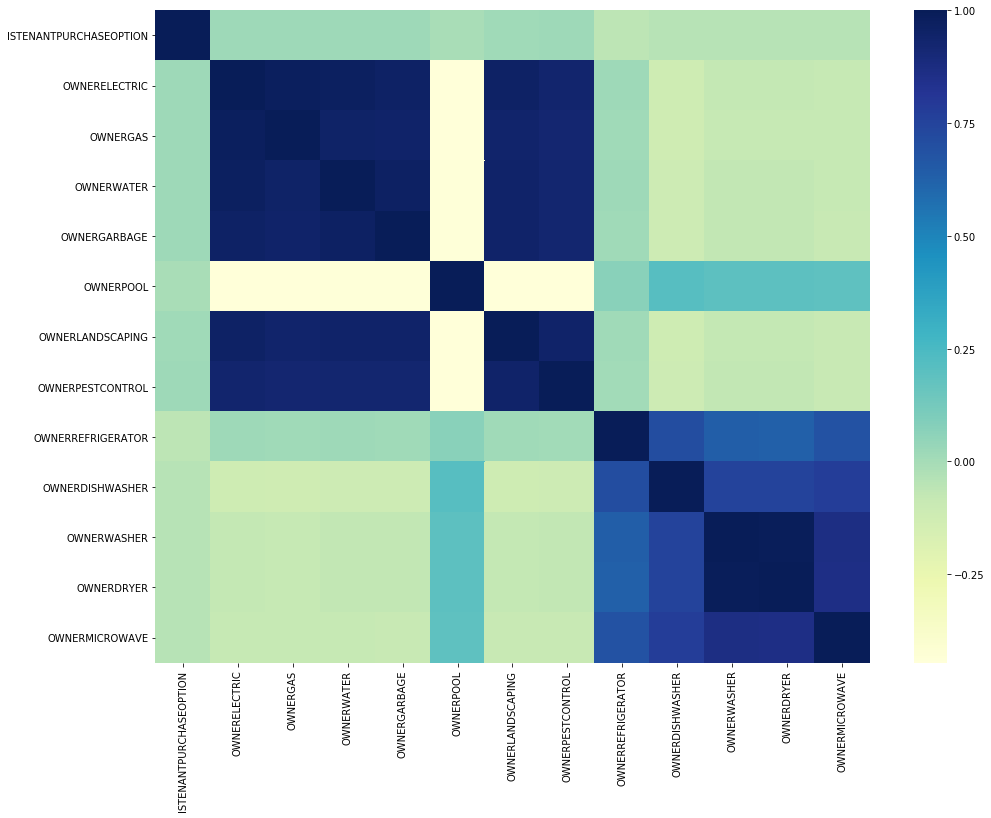

In [18]:
plt.figure(figsize=(16,12))
sns.heatmap(newdf.iloc[:,83:96].corr(), cmap = 'YlGnBu')

Text(0.5, 0, 'allowed funding types')

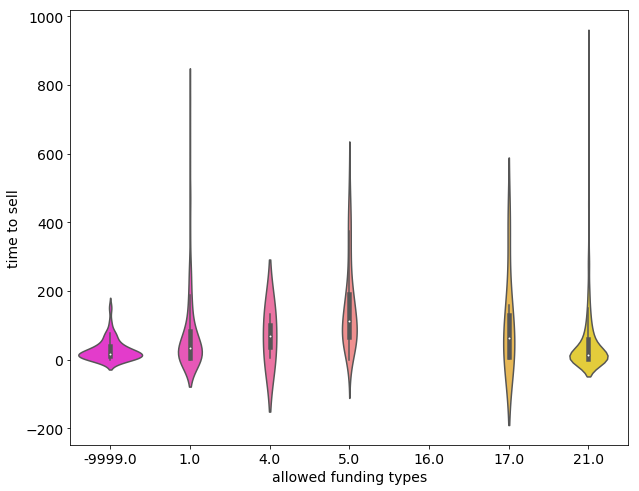

In [19]:
#### diff_days vs. ALLOWED FUNDING TYPES
plt.figure(figsize=(10,8))
sns.violinplot(z.ALLOWEDFUNDINGTYPES,z.diff_days,palette='spring')
plt.ylabel('time to sell',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('allowed funding types',fontsize=14)

Text(0, 0.5, 'Time to sell')

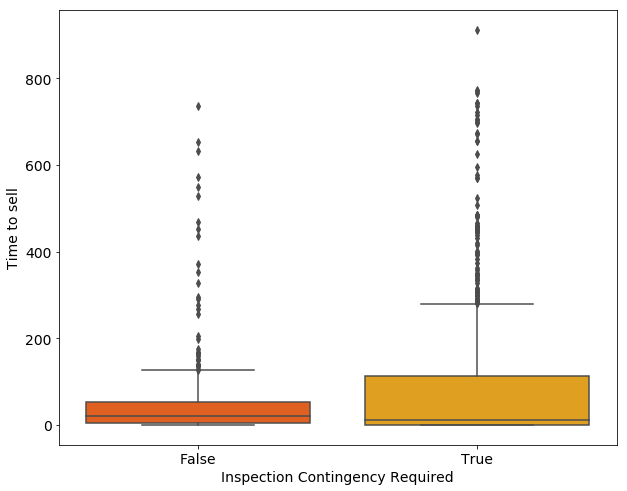

In [20]:
#### diff_days vs. INSPECTION_CONTINGENCY_REQUIRED
#### 留
plt.figure(figsize=(10,8))
sns.boxplot(z.INSPECTION_CONTINGENCY_REQUIRED,z.diff_days,palette='autumn')
plt.xlabel('Inspection Contingency Required',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time to sell',fontsize=14)

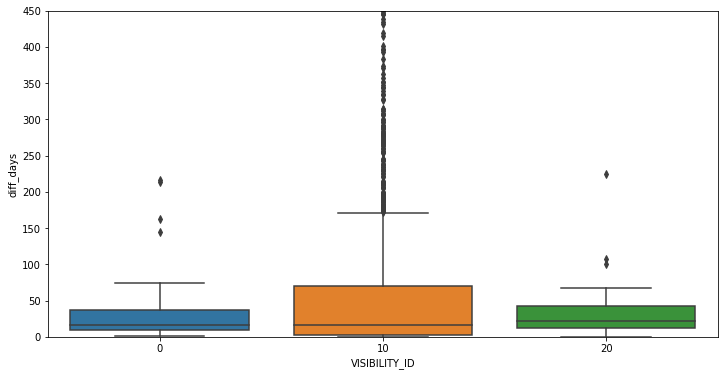

In [21]:
#### diff_days vs. VISIBILITY_ID
#留
plt.figure(figsize=(12,6))
plt.ylim([0,450])
sns.boxplot(z.VISIBILITY_ID,z.diff_days)

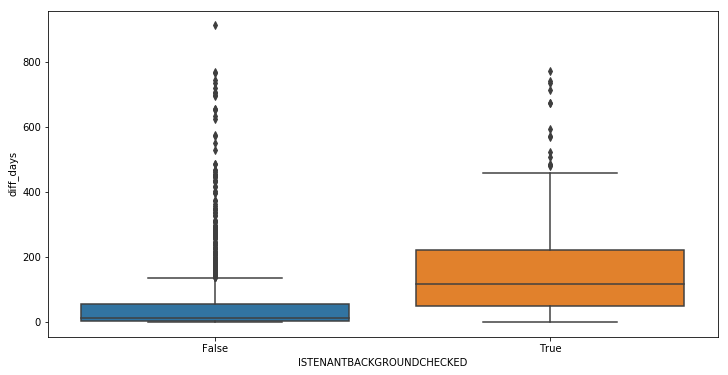

In [22]:
#### diff_days vs. IS TENANT BACKGROUND CHECKED
### 留
plt.figure(figsize=(12,6))
sns.boxplot(z.ISTENANTBACKGROUNDCHECKED,z.diff_days)

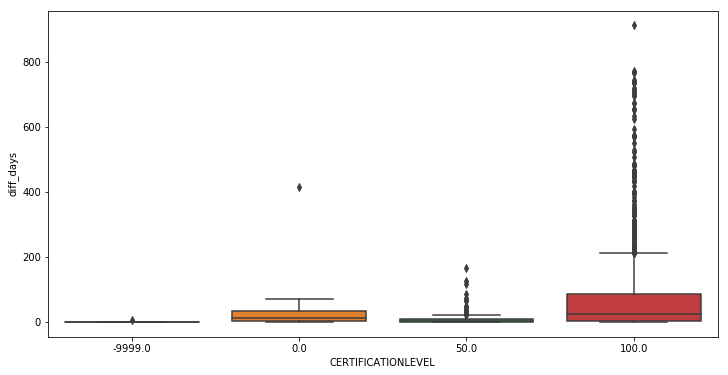

In [23]:
#### diff_days vs. CERTIFICATION LEVEL
####留
plt.figure(figsize=(12,6))
sns.boxplot(z.CERTIFICATIONLEVEL,z.diff_days)

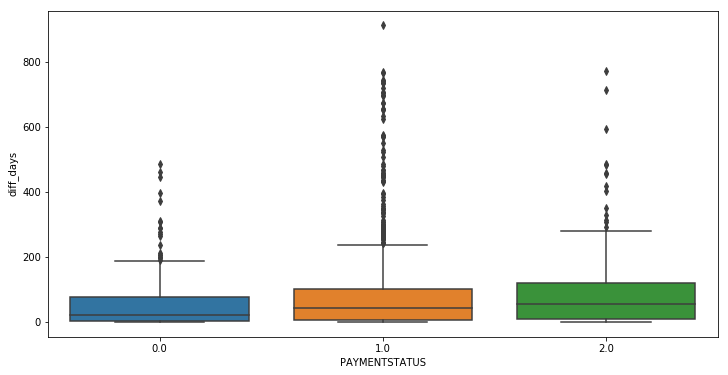

In [24]:
#### diff_days vs. PAYMENTSTATUS
plt.figure(figsize=(12,6))
sns.boxplot(z.PAYMENTSTATUS,z.diff_days)

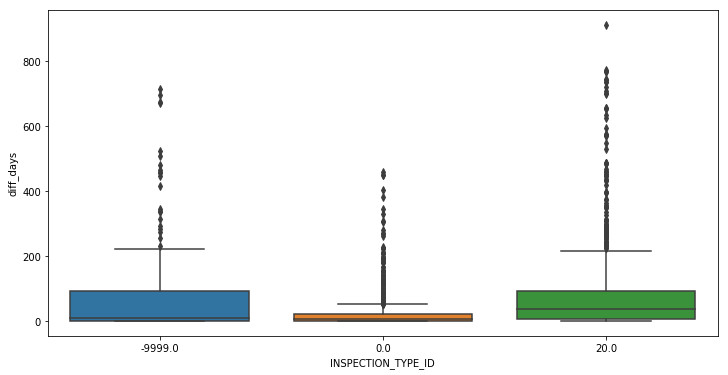

In [25]:
#### diff_days vs. INSPECTION_TYPE_ID
plt.figure(figsize=(12,6))
sns.boxplot(z.INSPECTION_TYPE_ID,z.diff_days)

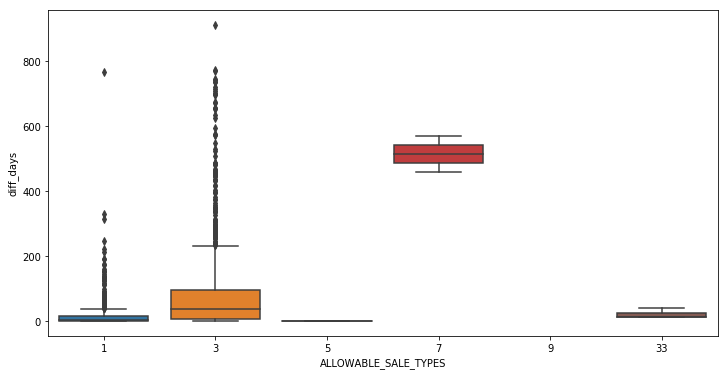

In [26]:
#### diff_days vs. ALLOWABLE_SALE_TYPES
plt.figure(figsize=(12,6))
sns.boxplot(z.ALLOWABLE_SALE_TYPES,z.diff_days)

### HAS OFFER OR NOT

<Figure size 1728x864 with 0 Axes>

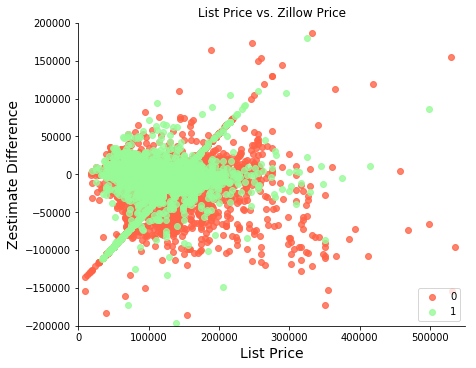

In [27]:
# List Price vs. Zillow Price
plt.figure(figsize=(24,12))
sns.lmplot( x="LIST_PRICE", y="ZESTIMATE_DIFFERENCE", data=newdf, fit_reg=False, hue='OFFER_OR_NOT',
           palette=["tomato", 'palegreen'],legend=False,aspect=16/12)
plt.xlim([0,550000])
plt.ylim([-200000,200000])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('List Price', fontsize=14)
plt.ylabel('Zestimate Difference', fontsize=14)
plt.legend(loc='lower right')
plt.title('List Price vs. Zillow Price')
plt.show()

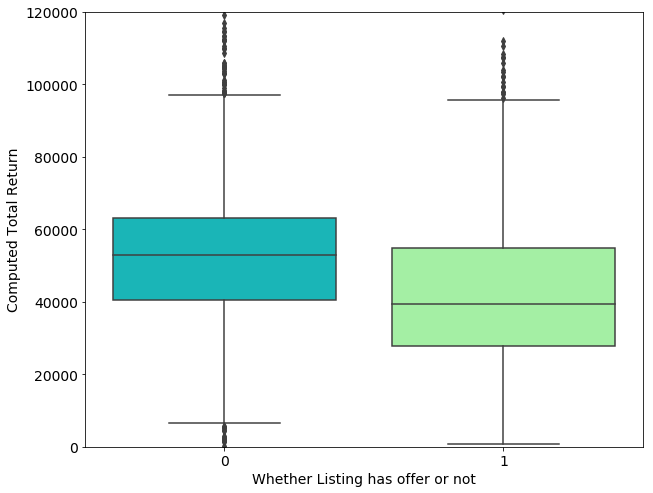

In [28]:
#### COMPUTEDTOTALRETURN 
plt.figure(figsize=(10,8))
sns.boxplot(newdf.OFFER_OR_NOT,newdf.COMPUTEDTOTALRETURN,palette=["darkturquoise", 'palegreen'])
plt.ylim([0,120000])
plt.xlabel('Whether Listing has offer or not', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Computed Total Return', fontsize=14)
plt.yticks(fontsize=14)

plt.show()

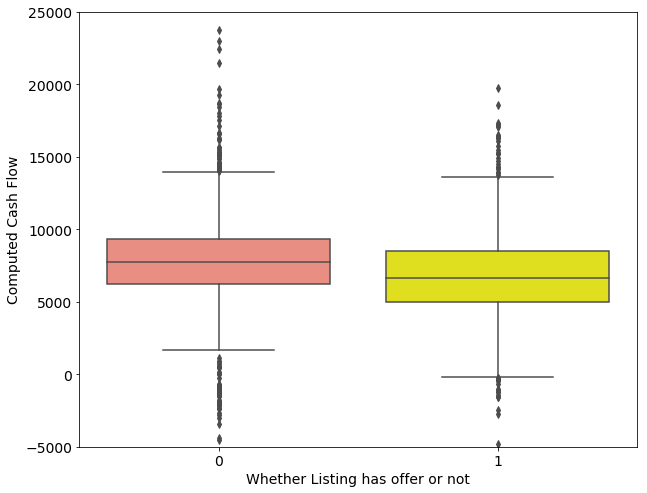

In [29]:
#### COMPUTEDCASHFLOW
plt.figure(figsize=(10,8))
sns.boxplot(newdf.OFFER_OR_NOT,newdf.COMPUTEDCASHFLOW,palette=['salmon','yellow'])
plt.ylim([-5000,25000])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Whether Listing has offer or not', fontsize=14)
plt.ylabel('Computed Cash Flow', fontsize=14)
plt.show()

<Figure size 1008x864 with 0 Axes>

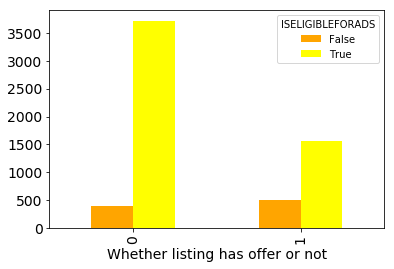

In [30]:
#### ISELIGIBLEFORADS
plt.figure(figsize=(14,12))
pd.crosstab(index=newdf.OFFER_OR_NOT, columns=newdf.ISELIGIBLEFORADS).loc[[0,1]]. plot(kind='bar',color=['orange','yellow'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Whether listing has offer or not', fontsize=14)
#plt.ylabel('Is Eligible for Ads', fontsize=14)
#plt.title('Is Eligible For Ads ',size = 15)
plt.show()

<Figure size 1008x864 with 0 Axes>

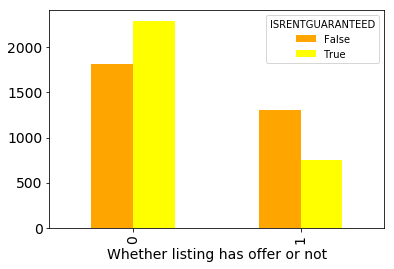

In [31]:
#### IS RENT GUARANTEED
plt.figure(figsize=(14,12))
pd.crosstab(index=newdf.OFFER_OR_NOT, columns=newdf.ISRENTGUARANTEED).loc[[0,1]]. plot(kind='bar',color=['orange','yellow'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Whether listing has offer or not', fontsize=14)
#plt.title('Is Rent Guaranteed',size = 15)
plt.show()

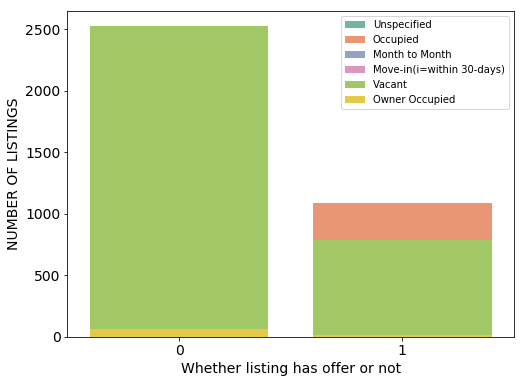

In [32]:
#### Occupacy
plt.figure(figsize=(8,6))
sns.countplot(x=newdf['OFFER_OR_NOT'],hue=newdf['OCCUPANCY'],palette='Set2',dodge=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('NUMBER OF LISTINGS',fontsize=14)
plt.xlabel('Whether listing has offer or not',fontsize=14)
plt.legend(['Unspecified', 'Occupied', 'Month to Month',
                                            'Move-in(i=within 30-days)', 'Vacant','Owner Occupied'],loc='upper right')
#plt.title('Occupacy',size = 15)
plt.show()

<Figure size 1440x1152 with 0 Axes>

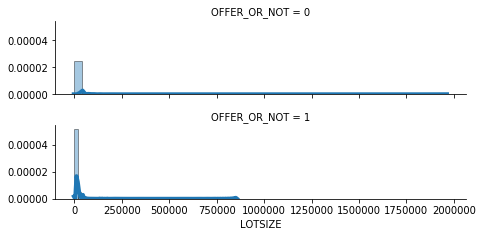

In [33]:
plt.figure(figsize=(20,16))
g = sns.FacetGrid(newdf, row="OFFER_OR_NOT",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "LOTSIZE", hist=True, kde=True,hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4});

<Figure size 1440x1152 with 0 Axes>

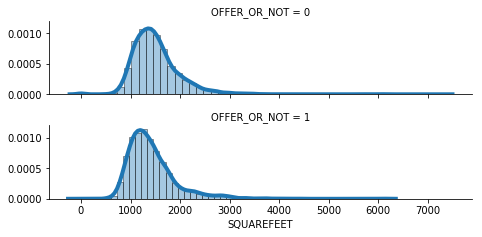

In [34]:
plt.figure(figsize=(20,16))
g = sns.FacetGrid(newdf, row="OFFER_OR_NOT",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "SQUAREFEET", hist=True, kde=True,hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4});

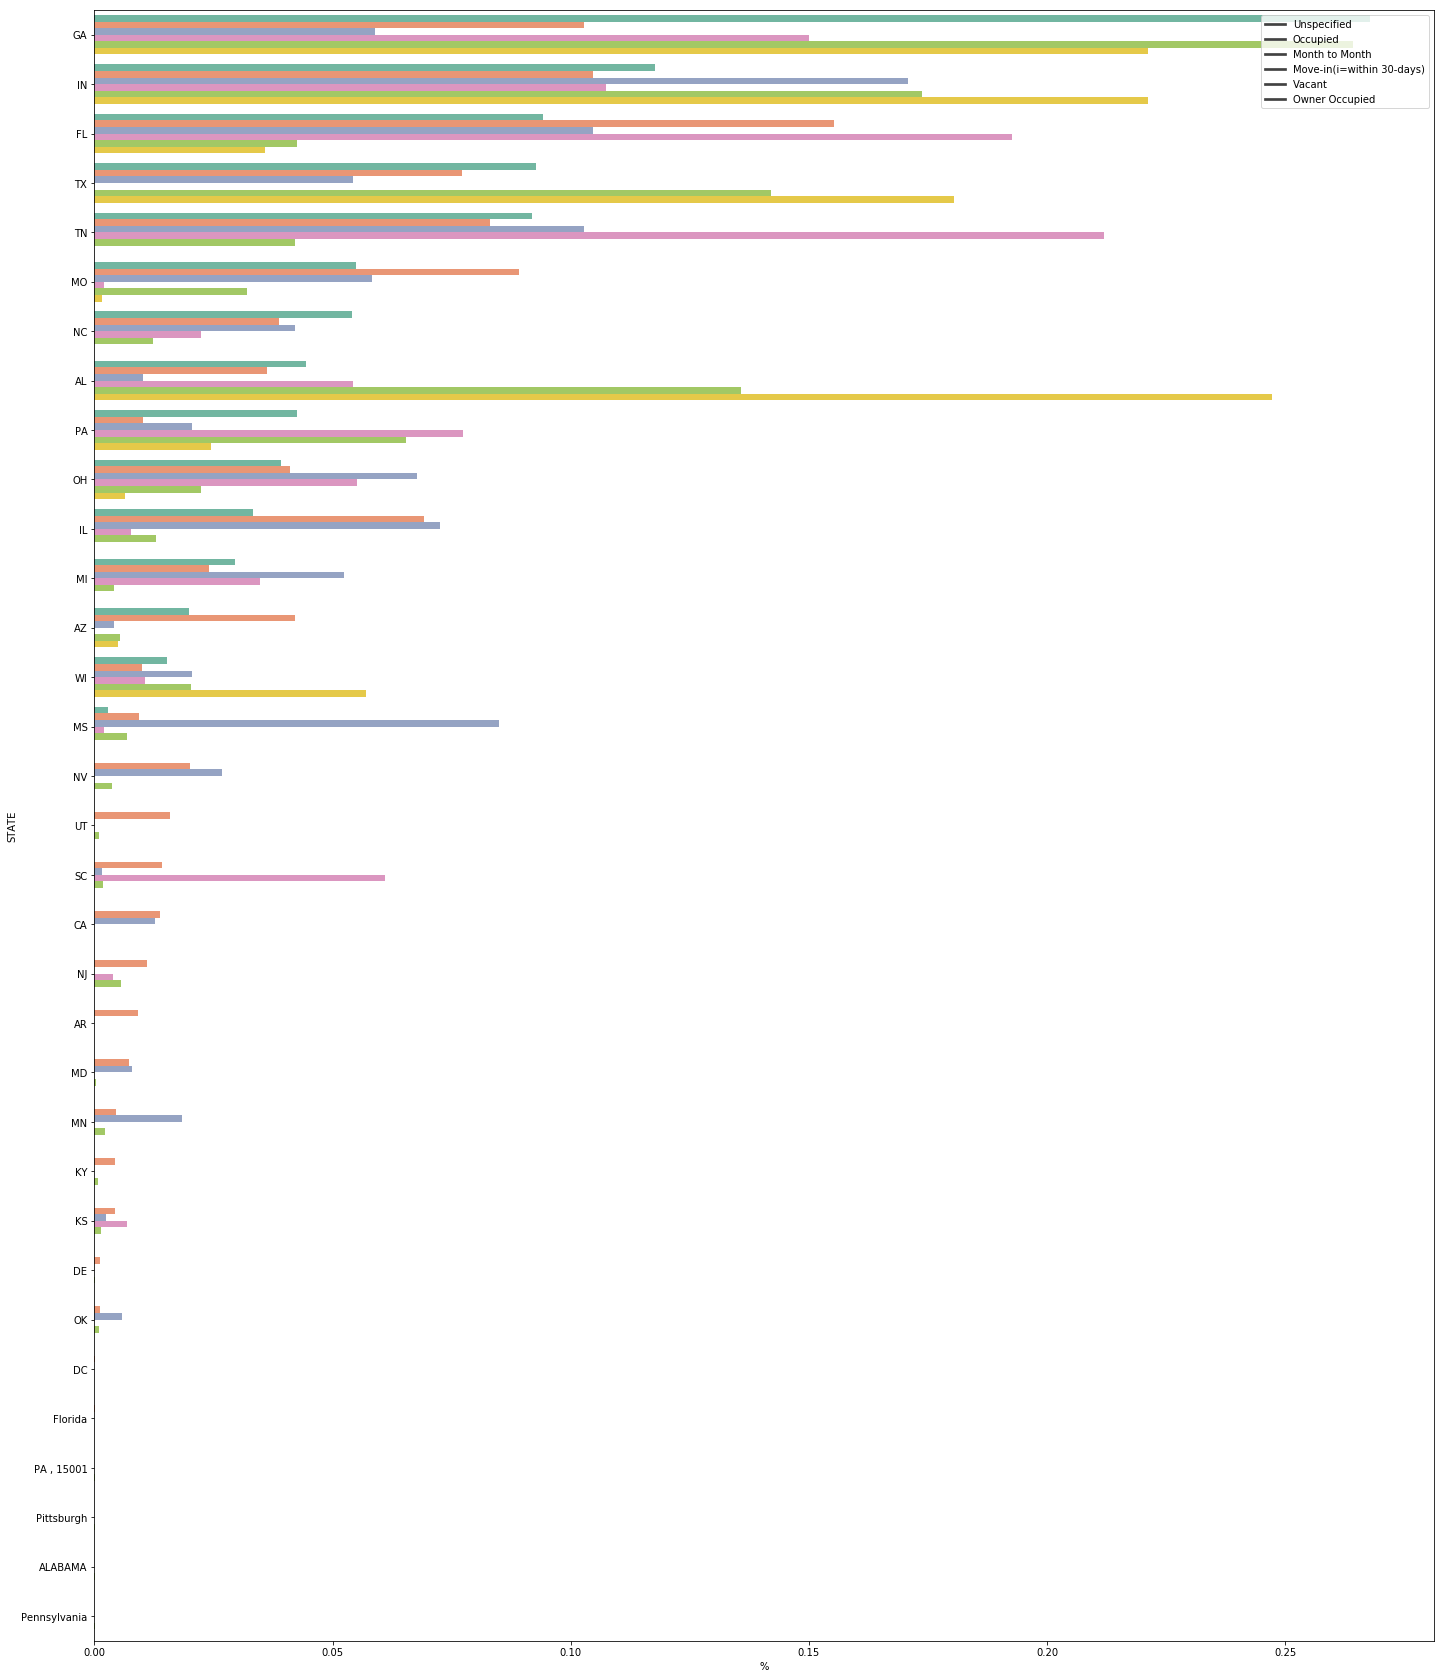

In [35]:
x, y, hue = 'STATE', '%', 'OCCUPANCY'
plt.figure(figsize=(24,30))
prop_df = (df_time[x]
           .groupby(df_time[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=y, y=x, hue=hue, data=prop_df,palette='Set2')
plt.legend(labels=['Unspecified', 'Occupied', 'Month to Month',
                                            'Move-in(i=within 30-days)', 'Vacant','Owner Occupied'])

Text(0, 0.5, 'STATE')

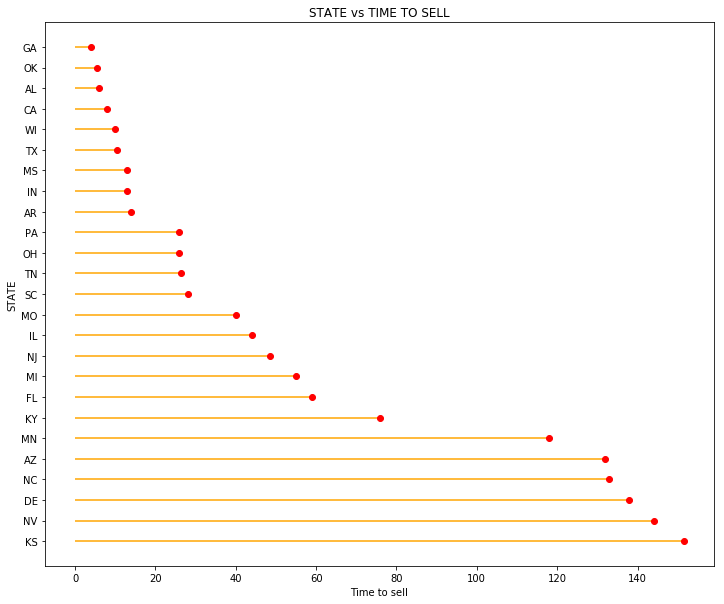

In [36]:
df_offer=newdf[newdf['OFFER_OR_NOT']==1]
df_no_offer=newdf[newdf['OFFER_OR_NOT']==0]
STATE=df_offer.groupby('STATE')['diff_days'].median()
STATE=STATE.sort_values(ascending=False)
STATE

plt.figure(figsize=(12,10))
plt.hlines(y=STATE.index, xmin=0, xmax=STATE.iloc[:], color='orange')
plt.plot(STATE.iloc[:],STATE.index, "o",color='red')
 
# Add titles and axis names
plt.yticks(STATE.index)
plt.title("STATE vs TIME TO SELL")
plt.xlabel('Time to sell')
plt.ylabel('STATE')

Text(0.5, 1.0, 'BEDROOMS VS SQUAREFEET (no offer)')

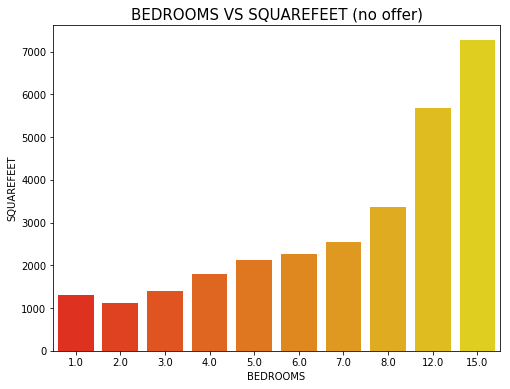

In [37]:
BED_no=df_no_offer.groupby('BEDROOMS')['SQUAREFEET'].median()
BED_no=BED_no.sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(BED_no.index,BED_no[:],palette='autumn')
plt.title('BEDROOMS VS SQUAREFEET (no offer)',size = 15)

Text(0.5, 1.0, 'BEDROOMS VS SQUAREFEET (offer)')

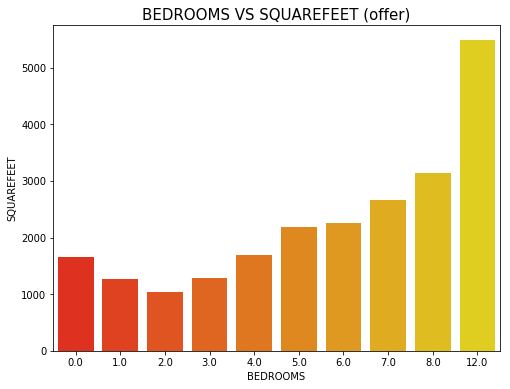

In [38]:
BED=df_offer.groupby('BEDROOMS')['SQUAREFEET'].median()
BED=BED.sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(BED.index,BED[:],palette='autumn')
plt.title('BEDROOMS VS SQUAREFEET (offer)',size = 15)

Text(0.5, 1.0, 'LISTINGS WITHOUT OFFER vs BEDROOMS')

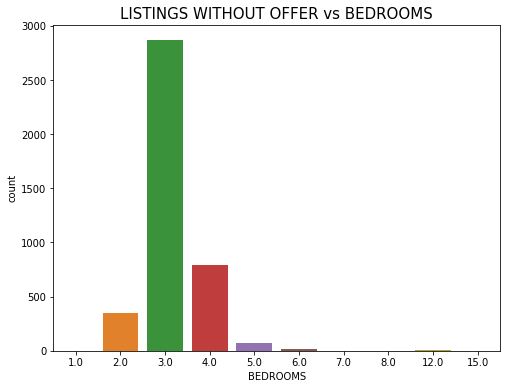

In [39]:
plt.figure(figsize=(8,6))
sns.countplot(df_no_offer['BEDROOMS'])
plt.title("LISTINGS WITHOUT OFFER vs BEDROOMS",size=15)

Text(0.5, 1.0, 'LISTINGS WITH OFFER vs BEDROOMS')

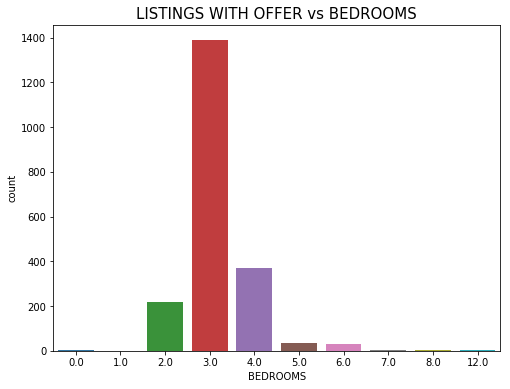

In [40]:
plt.figure(figsize=(8,6))
sns.countplot(df_offer['BEDROOMS'])
plt.title("LISTINGS WITH OFFER vs BEDROOMS",size=15)

Text(0.5, 1.0, 'BATHROOMS VS SQUAREFEET (no offer)')

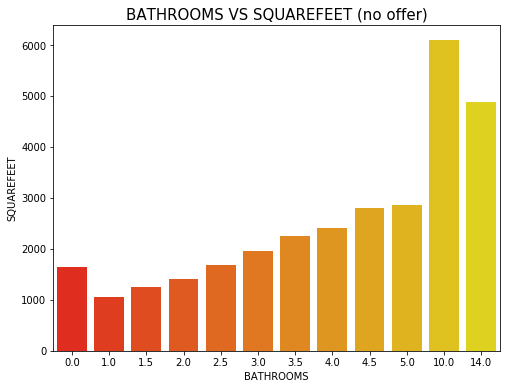

In [41]:
plt.figure(figsize=(8,6))
BATH=df_offer.groupby('BATHROOMS')['SQUAREFEET'].median()
BATH=BATH.sort_values(ascending=False)
sns.barplot(BATH.index,BATH[:],palette='autumn')
plt.title('BATHROOMS VS SQUAREFEET (no offer)',size = 15)

Text(0.5, 1.0, 'BATHROOMS VS SQUAREFEET (offer)')

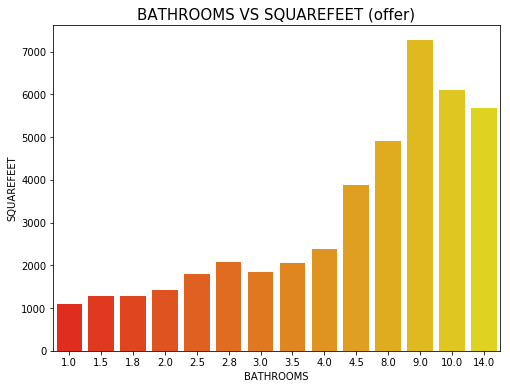

In [42]:
plt.figure(figsize=(8,6))
BATH_no=df_no_offer.groupby('BATHROOMS')['SQUAREFEET'].median()
BATH_no=BATH_no.sort_values(ascending=False)
sns.barplot(BATH_no.index,BATH_no[:],palette='autumn')
plt.title('BATHROOMS VS SQUAREFEET (offer)',size = 15)

In [43]:
df_no_offer['BATHROOMS']=df_no_offer['BATHROOMS'].replace(2.8,2.5)
df_no_offer['BATHROOMS']=df_no_offer['BATHROOMS'].replace(1.8,1.5)

Text(0.5, 1.0, 'NUMBER OF LISTINGS vs BATHROOMS (no offer)')

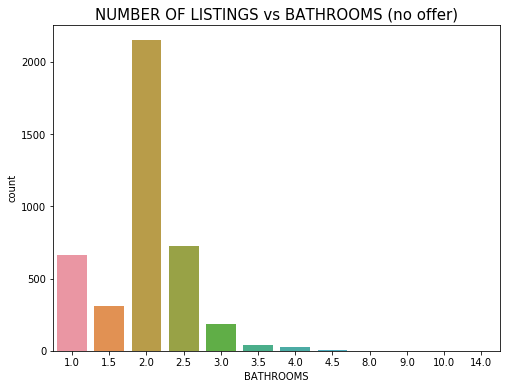

In [44]:
plt.figure(figsize=(8,6))
sns.countplot(df_no_offer['BATHROOMS'])
plt.title('NUMBER OF LISTINGS vs BATHROOMS (no offer)',size = 15)

Text(0.5, 1.0, 'NUMBER OF LISTINGS vs BATHROOMS (offer)')

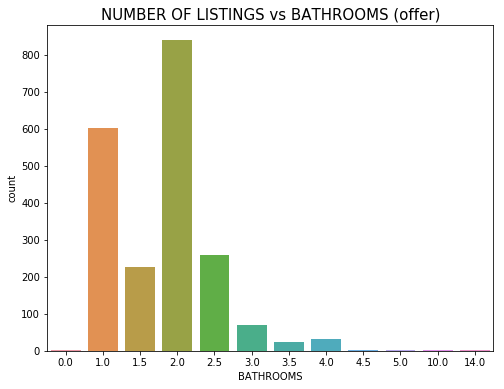

In [45]:
plt.figure(figsize=(8,6))
sns.countplot(df_offer['BATHROOMS'])
plt.title('NUMBER OF LISTINGS vs BATHROOMS (offer)',size = 15)

Text(0.5, 1.0, 'NUMBER OF OFFERS OF DIFFERENT LISTING SOURCES')

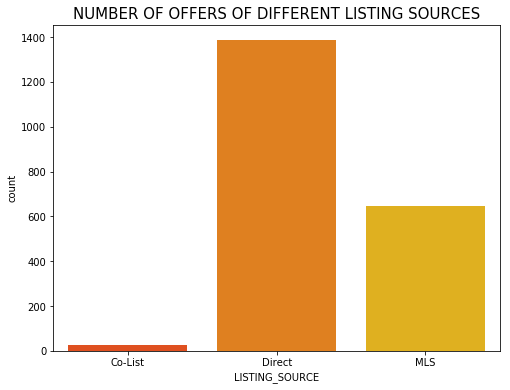

In [46]:
plt.figure(figsize=(8,6))
sns.countplot(df_offer['LISTING_SOURCE'],palette='autumn')
plt.title('NUMBER OF OFFERS OF DIFFERENT LISTING SOURCES',size = 15)

Text(0.5, 1.0, 'PERCENTAGE OF GETTING OFFERS OF DIFFERENT LISTING SOURCES')

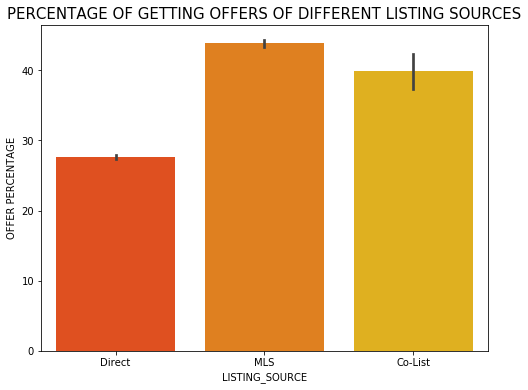

In [47]:
plt.figure(figsize=(8,6))
sns.barplot(x='LISTING_SOURCE',y='OFFER_OR_NOT',data=df,estimator=lambda x:sum(x==1)*100.0/len(x),palette='autumn')
plt.ylabel('OFFER PERCENTAGE')
plt.title('PERCENTAGE OF GETTING OFFERS OF DIFFERENT LISTING SOURCES',size = 15)

In [48]:
df_offer=newdf[newdf['OFFER_OR_NOT']==1]
df_no_offer=newdf[newdf['OFFER_OR_NOT']==0]
newdf['LISTING_INITIAL_PUBLISH_TS']=pd.to_datetime(newdf['LISTING_INITIAL_PUBLISH_TS'])
df_offer['EVENT_UTC']=pd.to_datetime(df_offer['EVENT_UTC'])
df_time=newdf.set_index('LISTING_INITIAL_PUBLISH_TS')
df_time['INITIAL_PUBLISH_MONTH']=df_time.index.month
df_offer=df_offer.set_index('EVENT_UTC')
df_offer['OFFER_MONTH']=df_offer.index.month

Text(0.5, 1.0, 'NUMBER OF LISTINGS PUBLISHED IN DIFFERENT MONTHS')

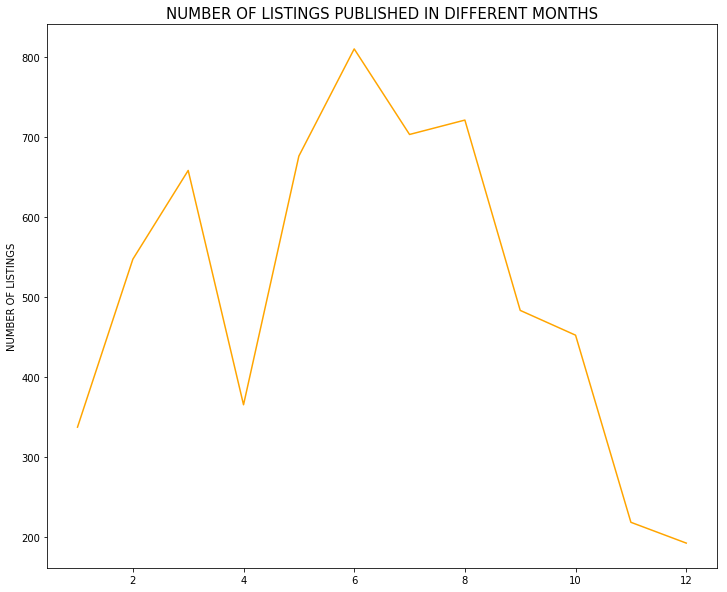

In [49]:
plt.figure(figsize=(12,10))
plt.plot(df_time.groupby('INITIAL_PUBLISH_MONTH').count()['LISTING_STATUS'],color='orange')
plt.ylabel('NUMBER OF LISTINGS')
plt.title('NUMBER OF LISTINGS PUBLISHED IN DIFFERENT MONTHS',size = 15)

Text(0.5, 1.0, 'NUMBER OF LISTINGS PUBLISHED IN DIFFERENT MONTHS GROUPBY OCCUPANCY')

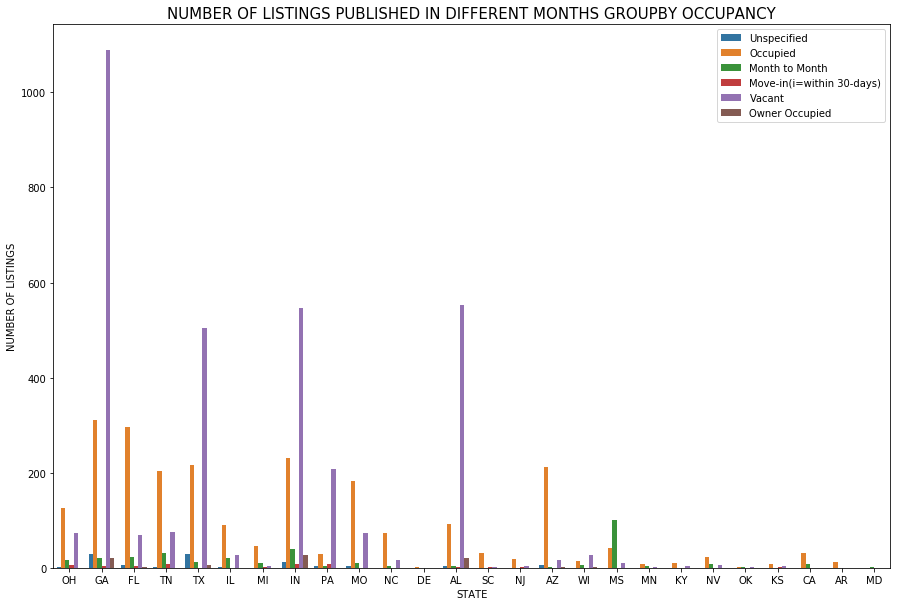

In [50]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_time['STATE'],hue=df_time['OCCUPANCY'],orient='h')
plt.ylabel('NUMBER OF LISTINGS')
plt.legend(['Unspecified', 'Occupied', 'Month to Month',
                                            'Move-in(i=within 30-days)', 'Vacant','Owner Occupied'],loc='upper right')
plt.title('NUMBER OF LISTINGS PUBLISHED IN DIFFERENT MONTHS GROUPBY OCCUPANCY',size = 15)

In [51]:
PERCENTAGE=df_time['OCCUPANCY'].groupby(df_time['STATE']).value_counts(normalize=True).rename('RATE').reset_index()

PERCENTAGE1=PERCENTAGE[PERCENTAGE['OCCUPANCY']==1].sort_values(by='RATE',ascending=False)
PERCENTAGE_VACANCY=PERCENTAGE[PERCENTAGE['OCCUPANCY']==100].sort_values(by='RATE',ascending=False)
PERCENTAGE_ONWEROCCUPIED=PERCENTAGE[PERCENTAGE['OCCUPANCY']==110].sort_values(by='RATE',ascending=False)

PERCENTAGE.sort_values('STATE')

,STATE,OCCUPANCY,RATE
0,AL,100.0,0.821429
1,AL,1.0,0.136905
2,AL,110.0,0.029762
3,AL,0.0,0.005952
4,AL,10.0,0.004464
5,AL,30.0,0.001488
6,AR,1.0,1.000000
10,AZ,10.0,0.004255
9,AZ,0.0,0.025532
11,AZ,110.0,0.004255


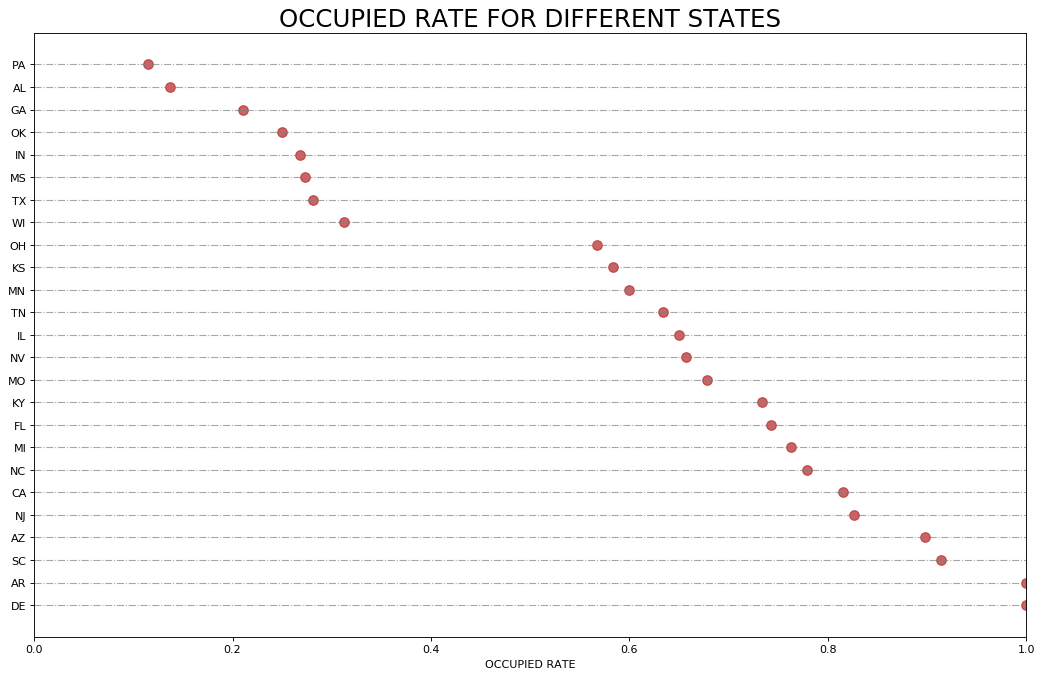

In [52]:
# Prepare Data
#df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")
#df = df_raw[['cty', 'manufacturer']].groupby('manufacturer').apply(lambda x: x.mean())
#df.sort_values('cty', inplace=True)
#df.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=PERCENTAGE1['STATE'], xmin=0, xmax=1,color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=PERCENTAGE1['STATE'], x=PERCENTAGE1['RATE'], s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('OCCUPIED RATE FOR DIFFERENT STATES', fontdict={'size':22})
ax.set_xlabel('OCCUPIED RATE')
ax.set_yticks(PERCENTAGE1['STATE'])
ax.set_yticklabels(PERCENTAGE1['STATE'], fontdict={'horizontalalignment': 'right'})
ax.set_xlim(0, 1)
plt.show()

Text(0.5, 1.0, 'OCCUPIED RATE FOR DIFFERENT STATES')

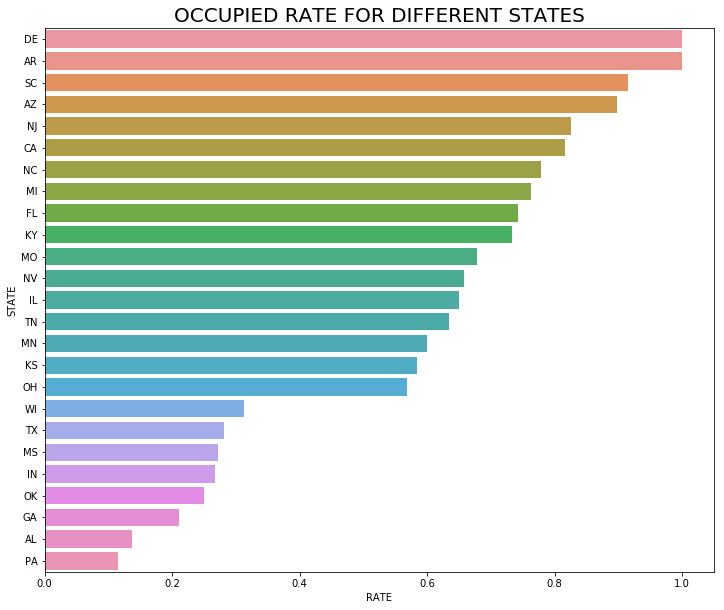

In [53]:
plt.figure(figsize=(12,10))
sns.barplot(PERCENTAGE1['RATE'],PERCENTAGE1['STATE'])
plt.title('OCCUPIED RATE FOR DIFFERENT STATES',size=20)

Text(0.5, 1.0, 'VACANCY RATE FOR DIFFERENT STATES')

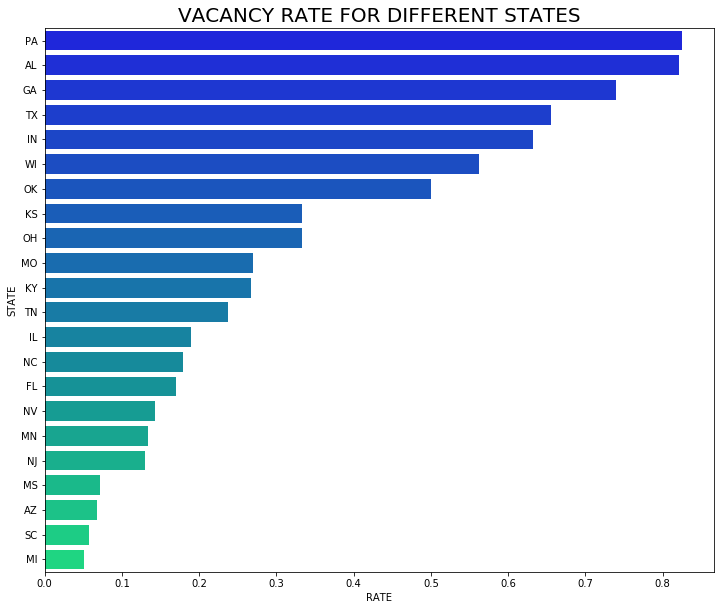

In [54]:
plt.figure(figsize=(12,10))
sns.barplot(PERCENTAGE_VACANCY['RATE'],PERCENTAGE_VACANCY['STATE'],palette='winter')
plt.title('VACANCY RATE FOR DIFFERENT STATES',size=20)

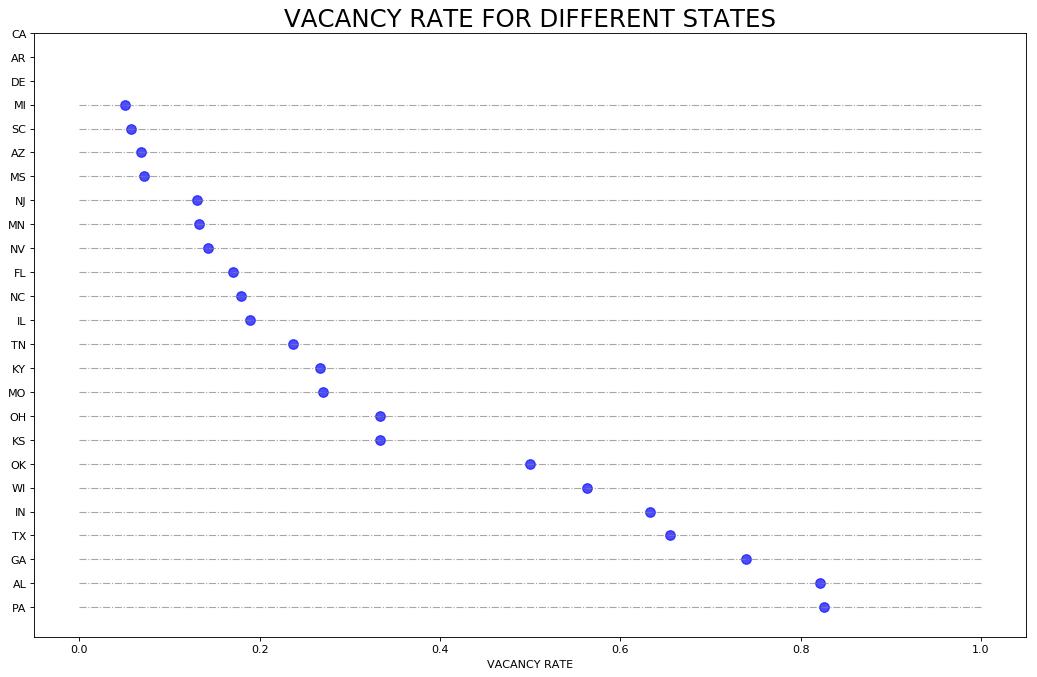

In [55]:
# Title, Label, Ticks and Ylim
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=PERCENTAGE_VACANCY['STATE'], xmin=0, xmax=1,color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(PERCENTAGE_VACANCY['RATE'],PERCENTAGE_VACANCY['STATE'], s=75, color='blue', alpha=0.7)
ax.set_title('VACANCY RATE FOR DIFFERENT STATES', fontdict={'size':22})
ax.set_xlabel('VACANCY RATE')
ax.set_yticks(PERCENTAGE1['STATE'])
ax.set_yticklabels(PERCENTAGE1['STATE'], fontdict={'horizontalalignment': 'right'})
plt.show()

Text(0.5, 1.0, 'ONWER OCCUPIED RATE FOR DIFFERENT STATES')

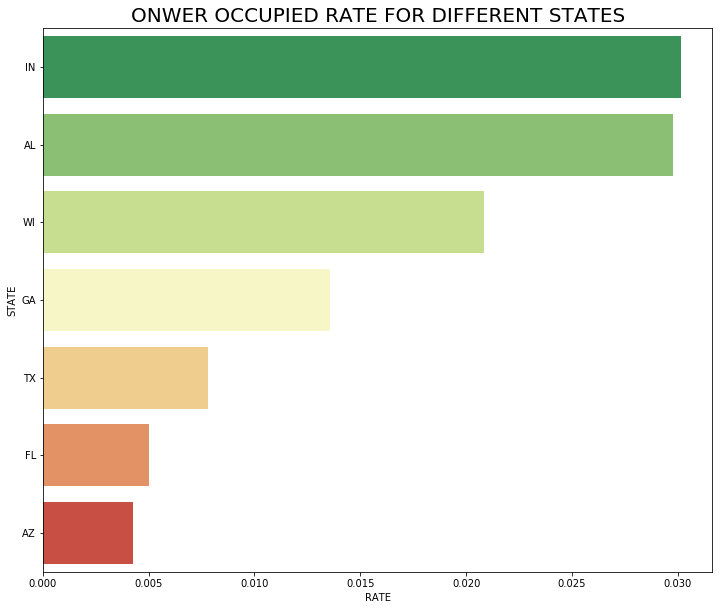

In [56]:
plt.figure(figsize=(12,10))
sns.barplot(PERCENTAGE_ONWEROCCUPIED['RATE'].sort_values(),PERCENTAGE_ONWEROCCUPIED['STATE'],palette='RdYlGn_r')
plt.title('ONWER OCCUPIED RATE FOR DIFFERENT STATES',size=20)

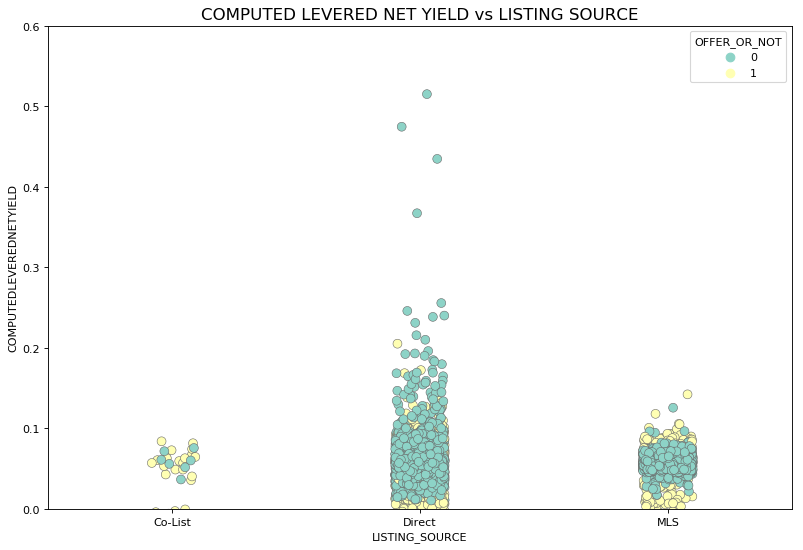

In [59]:
# Draw Stripplot
fig, ax = plt.subplots(figsize=(12,8), dpi= 80)    
sns.stripplot(df_time['LISTING_SOURCE'], df_time['COMPUTEDLEVEREDNETYIELD'],hue=df_time['OFFER_OR_NOT'],palette='Set3', size=8, ax=ax, linewidth=.5)
plt.ylim([0,0.6])
# Decorations
plt.title('COMPUTED LEVERED NET YIELD vs LISTING SOURCE', fontsize=15)
plt.show()

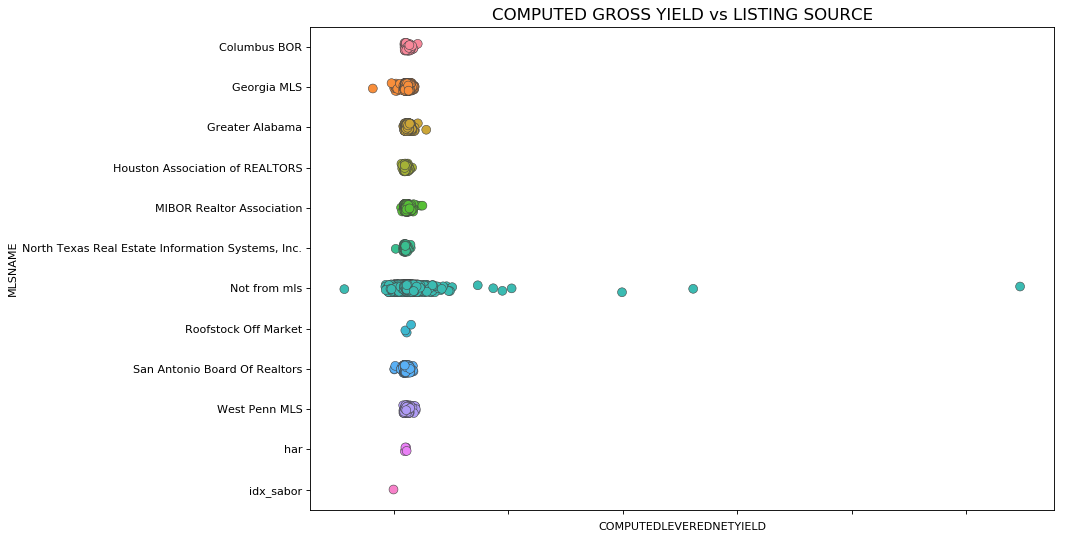

In [58]:
# Draw Stripplot
fig, ax = plt.subplots(figsize=(12,8), dpi= 80)    
a=sns.stripplot(df_time['COMPUTEDLEVEREDNETYIELD'],df_time['MLSNAME'], size=8, ax=ax, linewidth=.5)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
a.set_xticklabels(labels,rotation=90)
# Decorations
plt.title('COMPUTED GROSS YIELD vs LISTING SOURCE', fontsize=15)
plt.show()

## Training Dataset

In [62]:
import pandas as pd
pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [63]:
buyer=pd.read_csv('roofstock_marketplace_buyers_full.csv')
listing=pd.read_csv('roofstock_marketplace_listing_historical_full.csv')
offer=pd.read_csv('roofstock_marketplace_offers_full.csv')
transaction=pd.read_csv('roofstock_marketplace_transactions_full.csv')
site=pd.read_csv('site_activity.csv')
final=pd.read_csv('final_df.csv')

final['EVENT_UTC']=pd.to_datetime(final['EVENT_UTC'])
final['CREATED_TS']=pd.to_datetime(final['CREATED_TS'])
final['diff_days']=final.apply(lambda x: x['EVENT_UTC']- x['CREATED_TS'], axis=1)
final['diff_days']=final['diff_days'].map(lambda x: x.days)

listing1=listing[listing['LIST_PRICE'].isnull()==False]
total_nooffer=listing1[~listing1['LISTING_ID'].isin(list(final['LISTING_ID'].unique()))]
nooffer=total_nooffer.groupby('LISTING_ID').apply(lambda t: t[t.REC_START_TS==t.REC_START_TS.min()]).drop_duplicates()

nooffer['EVENT_UTC']='2019-08-18 19:16:50.144 +0000'
nooffer['OFFER_ID']=1234567
nooffer['OFFER_PRICE']=-9999
nooffer['discount']=1
nooffer['diff_days']=1001
nooffer=nooffer.drop('PROPERTYSUMMARY',axis=1)

use_df=pd.concat([final,nooffer])

In [64]:
#use_listing=listing.sort_values("REC_END_TS",ascending=True)
use_listing=listing.dropna(subset=['LIST_PRICE'])
#use_listing=use_listing.drop_duplicates(subset=['LISTING_ID','LIST_PRICE'],keep='first')
#use_listing=use_listing.reset_index().drop('index',axis=1)

In [65]:
dup_list=list(set(use_listing)-set(droplist))
use_listing=use_listing.sort_values("REC_END_TS",ascending=True)
use_listing=use_listing.drop_duplicates(subset=dup_list,keep='first')
offer0=offer[offer['OFFER_DIRECTION']=='BuyerToSeller'][['EVENT_UTC','OFFER_PRICE','LISTING_ID']]
tt=transaction[transaction['OFFER_ID']==-99][['EVENT_UTC','SALE_PRICE','LISTING_ID']]
tt=tt.rename(columns={'SALE_PRICE':'OFFER_PRICE'})
offer0=pd.concat([offer0,tt])


In [129]:
utc=[]
offerprice=[]
for i in tqdm(list(use_listing.index)):
    c_id=use_listing['LISTING_ID'][i]
    c_time=use_listing['REC_END_TS'][i]
    use_offer=offer0[offer0['LISTING_ID']==c_id]
    if len(use_offer)==0:
        utc.append('2020-08-18 19:16:50.144 +0011')
        offerprice.append(-9)
    else:
        offer1=use_offer[use_offer['EVENT_UTC']>c_time]
        if len(offer1)==0:
            utc.append('BUXING')
            offerprice.append(-9)
        else:
            offer1.sort_values("EVENT_UTC",inplace=True,ascending=True)
            utc.append(offer1.iloc[0]['EVENT_UTC'])
            offerprice.append(offer1.iloc[0]['OFFER_PRICE'])

100%|██████████| 214410/214410 [16:16<00:00, 219.66it/s] 


In [130]:
use_listing['EVENT_UTC']=utc
use_listing['OFFER_PRICE']=offerprice

In [133]:
f_use_listing=use_listing.drop(use_listing[use_listing['EVENT_UTC']=='BUXING'].index)
f_use_listing['EVENT_UTC']=pd.to_datetime(f_use_listing['EVENT_UTC'])
f_use_listing['CREATED_TS']=pd.to_datetime(f_use_listing['CREATED_TS'])
f_use_listing['diff_days']=f_use_listing.apply(lambda x: x['EVENT_UTC']- x['CREATED_TS'], axis=1)
f_use_listing['diff_days']=f_use_listing['diff_days'].map(lambda x: x.days)
f_use_listing=f_use_listing.drop('PROPERTYSUMMARY',axis=1)
for i in list(f_use_listing[f_use_listing['EVENT_UTC']=='2020-08-18 19:16:50.144 +0011'].index):
    f_use_listing.set_value(i, 'diff_days', 1015)

In [134]:
f_use_listing.to_csv('latter_final.csv')

In [135]:
buyer=pd.read_csv('roofstock_marketplace_buyers_full.csv')
listing=pd.read_csv('roofstock_marketplace_listing_historical_full.csv')
offer=pd.read_csv('roofstock_marketplace_offers_full.csv')
transaction=pd.read_csv('roofstock_marketplace_transactions_full.csv')
site=pd.read_csv('site_activity.csv')

In [136]:
aa=listing[listing['LISTING_PUBLISH_TS'].isnull()==False]
bb=aa[aa['LISTING_INITIAL_PUBLISH_TS'].isnull()==True]

In [137]:
aa=listing[listing['LISTING_INITIAL_PUBLISH_TS'].isnull()==True]
ll=list(aa['LISTING_ID'].unique())

In [138]:
cc=(offer['LISTING_ID']+transaction['LISTING_ID']).unique()

In [139]:
xx=0
for i in ll:
    if i in cc:
        xx=+1

In [140]:
pp=f_use_listing.dropna(subset=['LISTING_INITIAL_PUBLISH_TS','LISTING_PUBLISH_TS','LISTING_INTIAL_PUBLISH_DATE','LISTING_PUBLISH_DATE'],axis=0,how='all') 


In [141]:
dd_list=list(set(f_use_listing['LISTING_ID'].unique())-set(pp['LISTING_ID'].unique()))

In [142]:
abc=listing[['LISTING_ID','LISTING_INITIAL_PUBLISH_TS']].dropna().drop_duplicates().groupby('LISTING_ID').apply(lambda t: t[t.LISTING_INITIAL_PUBLISH_TS==t.LISTING_INITIAL_PUBLISH_TS.min()]).drop_duplicates()


In [143]:
abc=abc.drop('LISTING_ID',axis=1).reset_index().drop('level_1',axis=1)

In [144]:
abc_dict=abc.set_index('LISTING_ID')['LISTING_INITIAL_PUBLISH_TS'].to_dict()

In [145]:
df=pd.read_csv('variables4.csv')
df=df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
STATE=pd.get_dummies(df['STATE'],dummy_na=True,prefix='STATE')
df=pd.concat([df,STATE],axis=1)
df=df.drop('STATE',axis=1)

In [147]:
df['EVENT_UTC']=list(f_use_listing['EVENT_UTC'])
df['LISTING_ID']=list(f_use_listing['LISTING_ID'])

In [149]:
df=df[df['LISTING_ID'].isin(list(abc['LISTING_ID']))]

In [151]:
df['LISTING_INITIAL_PUBLISH_TS']=df['LISTING_ID'].map(lambda x:abc_dict[x])
df['EVENT_UTC']=pd.to_datetime(df['EVENT_UTC'])
df['LISTING_INITIAL_PUBLISH_TS']=pd.to_datetime(df['LISTING_INITIAL_PUBLISH_TS'])
df['diff_days']=df.apply(lambda x: x['EVENT_UTC']- x['LISTING_INITIAL_PUBLISH_TS'], axis=1)
df['diff_days']=df['diff_days'].map(lambda x: x.days)

In [152]:
for i in df[df['EVENT_UTC']=='2020-08-18 19:05:50.144'].index:
    df.set_value(i,'diff_days',920)

In [154]:
df=df[df['LISTING_ID']!=1625006]
df[['LISTING_ID']].drop_duplicates().to_csv('zillow_listing.csv',index=False)

In [156]:
drop_listing=list(set(f_use_listing['LISTING_ID'])-set(df['LISTING_ID']))+[1625006]

In [158]:
before_dummy=pd.read_csv('newfillnafinal.csv').drop('Unnamed: 0',axis=1)
before_dummy['EVENT_UTC']=list(f_use_listing['EVENT_UTC'])
before_dummy['LISTING_ID']=list(f_use_listing['LISTING_ID'])
before_dummy=before_dummy[before_dummy['LISTING_ID'].isin(list(abc['LISTING_ID']))]
before_dummy['LISTING_INITIAL_PUBLISH_TS']=before_dummy['LISTING_ID'].map(lambda x:abc_dict[x])
before_dummy['EVENT_UTC']=pd.to_datetime(before_dummy['EVENT_UTC'])
before_dummy['LISTING_INITIAL_PUBLISH_TS']=pd.to_datetime(before_dummy['LISTING_INITIAL_PUBLISH_TS'])
before_dummy['diff_days']=df.apply(lambda x: x['EVENT_UTC']- x['LISTING_INITIAL_PUBLISH_TS'], axis=1)
before_dummy['diff_days']=before_dummy['diff_days'].map(lambda x: x.days)
for i in before_dummy[before_dummy['EVENT_UTC']=='2020-08-18 19:05:50.144'].index:
    before_dummy.set_value(i,'diff_days',920)
before_dummy=before_dummy[before_dummy['LISTING_ID']!=1625006]

before_dummy.to_csv('eda_without_dummy.csv',index=False)

In [160]:
newdf=before_dummy
#### Dummy Variables

ALLOWABLE_SALE_TYPES=pd.get_dummies(newdf['ALLOWABLE_SALE_TYPES'],dummy_na=False,prefix='ALLOWABLE_SALE_TYPES')
newdf=pd.concat([newdf,ALLOWABLE_SALE_TYPES],axis=1)
newdf=newdf.drop('ALLOWABLE_SALE_TYPES',axis=1)

ALLOWEDFUNDINGTYPES=pd.get_dummies(newdf['ALLOWEDFUNDINGTYPES'],dummy_na=False,prefix='ALLOWEDFUNDINGTYPES')
newdf=pd.concat([newdf,ALLOWEDFUNDINGTYPES],axis=1)
newdf=newdf.drop('ALLOWEDFUNDINGTYPES',axis=1)

CBSA_CODE=pd.get_dummies(newdf['CBSA_CODE'],dummy_na=False,prefix='CBSA_CODE')
newdf=pd.concat([newdf,CBSA_CODE],axis=1)
newdf=newdf.drop('CBSA_CODE',axis=1)

CERTIFICATIONLEVEL=pd.get_dummies(newdf['CERTIFICATIONLEVEL'],dummy_na=False,prefix='CERTIFICATIONLEVEL')
newdf=pd.concat([newdf,CERTIFICATIONLEVEL],axis=1)
newdf=newdf.drop('CERTIFICATIONLEVEL',axis=1)

TITLESTATUS=pd.get_dummies(newdf['TITLESTATUS'],dummy_na=True,prefix='TITLESTATUS')
newdf=pd.concat([newdf,TITLESTATUS],axis=1)
newdf=newdf.drop('TITLESTATUS',axis=1)

FLOODRISKSCORE=pd.get_dummies(newdf['FLOODRISKSCORE'],dummy_na=True,prefix='FLOODRISKSCORE')
newdf=pd.concat([newdf,FLOODRISKSCORE],axis=1)
newdf=newdf.drop('FLOODRISKSCORE',axis=1)

VISIBILITY_ID=pd.get_dummies(newdf['VISIBILITY_ID'],dummy_na=False,prefix='VISIBILITY_ID')
newdf=pd.concat([newdf,VISIBILITY_ID],axis=1)
newdf=newdf.drop('VISIBILITY_ID',axis=1)

KITCHENCONDITIONID=pd.get_dummies(newdf['KITCHENCONDITIONID'],dummy_na=False,prefix='KITCHENCONDITIONID')
newdf=pd.concat([newdf,KITCHENCONDITIONID],axis=1)
newdf=newdf.drop('KITCHENCONDITIONID',axis=1)

LANDSCAPINGCONDITIONID=pd.get_dummies(newdf['LANDSCAPINGCONDITIONID'],dummy_na=False,prefix='LANDSCAPINGCONDITIONID')
newdf=pd.concat([newdf,LANDSCAPINGCONDITIONID],axis=1)
newdf=newdf.drop('LANDSCAPINGCONDITIONID',axis=1)


LEASINGSTATUS=pd.get_dummies(newdf['LEASINGSTATUS'],dummy_na=True,prefix='LEASINGSTATUS')
newdf=pd.concat([newdf,LEASINGSTATUS],axis=1)
newdf=newdf.drop('LEASINGSTATUS',axis=1)

LISTING_SOURCE=pd.get_dummies(newdf['LISTING_SOURCE'],dummy_na=False,prefix='LISTING_SOURCE')
newdf=pd.concat([newdf,LISTING_SOURCE],axis=1)
newdf=newdf.drop('LISTING_SOURCE',axis=1)

LISTING_STATUS=pd.get_dummies(newdf['LISTING_STATUS'],dummy_na=False,prefix='LISTING_STATUS')
newdf=pd.concat([newdf,LISTING_STATUS],axis=1)
newdf=newdf.drop('LISTING_STATUS',axis=1)

MARKETPLACESORTORDER=pd.get_dummies(newdf['MARKETPLACESORTORDER'],dummy_na=False,prefix='MARKETPLACESORTORDER')
newdf=pd.concat([newdf,MARKETPLACESORTORDER],axis=1)
newdf=newdf.drop('MARKETPLACESORTORDER',axis=1)

MARKET_ID=pd.get_dummies(newdf['MARKET_ID'],dummy_na=False,prefix='MARKET_ID')
newdf=pd.concat([newdf,MARKET_ID],axis=1)
newdf=newdf.drop('MARKET_ID',axis=1)

MLSNAME=pd.get_dummies(newdf['MLSNAME'],dummy_na=False,prefix='MLSNAME')
newdf=pd.concat([newdf,MLSNAME],axis=1)
newdf=newdf.drop('MLSNAME',axis=1)

PAYMENTSTATUS=pd.get_dummies(newdf['PAYMENTSTATUS'],dummy_na=True,prefix='PAYMENTSTATUS')
newdf=pd.concat([newdf,PAYMENTSTATUS],axis=1)
newdf=newdf.drop('PAYMENTSTATUS',axis=1)

PLUMBINGCONDITIONID=pd.get_dummies(newdf['PLUMBINGCONDITIONID'],dummy_na=False,prefix='PLUMBINGCONDITIONID')
newdf=pd.concat([newdf,PLUMBINGCONDITIONID],axis=1)
newdf=newdf.drop('PLUMBINGCONDITIONID',axis=1)

ROOFCONDITIONID=pd.get_dummies(newdf['ROOFCONDITIONID'],dummy_na=False,prefix='ROOFCONDITIONID')
newdf=pd.concat([newdf,ROOFCONDITIONID],axis=1)
newdf=newdf.drop('ROOFCONDITIONID',axis=1)

STATE=pd.get_dummies(newdf['STATE'],dummy_na=False,prefix='STATE')
newdf=pd.concat([newdf,STATE],axis=1)
newdf=newdf.drop('STATE',axis=1)

In [161]:
newdf.to_csv('without_estimate.csv', index = False)

In [162]:
newdf['DISCOUNT']=newdf['OFFER_PRICE']/newdf['LIST_PRICE']

## PCA

In [164]:
from sklearn.decomposition import PCA
PCA_computed = PCA(n_components=8)
PCA_com = PCA_computed.fit_transform(df.iloc[:,52:70])
principal_com_Df = pd.DataFrame(data = PCA_com
             , columns = ['COM_PC1', 'COM_PC2','COM_PC3','COM_PC4','COM_PC5','COM_PC6','COM_PC7','COM_PC8'])

In [165]:
principal_com_Df.head()

,COM_PC1,COM_PC2,COM_PC3,COM_PC4,COM_PC5,COM_PC6,COM_PC7,COM_PC8
0,-99387.456251,-3291.681400,2275.814499,-116.304900,1160.308573,-37.173049,-803.750094,-5.396352
1,-99387.456252,-3291.681443,2275.814790,-116.304935,1160.363293,-37.146755,-804.054990,3.598244
2,-99389.502053,-3283.980591,2195.852167,-323.083403,1165.736099,-48.678350,-628.855345,0.534761
3,-99391.046062,-3278.054335,2135.032123,-477.041026,1195.681799,-118.935423,358.123782,-56.038059
4,-99386.944801,-3293.606646,2295.805373,-64.610309,1159.006412,-34.270429,-847.778677,2.115465
